In [21]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import json

In [22]:
SPARCS_df = pd.read_csv('./Hospital_Inpatient_Discharges__SPARCS_De-Identified___Cost_Transparency__Beginning_2009_20250419.csv')
SPARCS_df.head(5)

,Year,Facility Id,Facility Name,APR DRG Code,APR Severity of Illness Code,APR DRG Description,APR Severity of Illness Description,APR Medical Surgical Code,APR Medical Surgical Description,Discharges,Mean Charge,Median Charge,Mean Cost,Median Cost
0,2016,4,Albany Memorial Hospital,194,1,Heart Failure,Minor,M,Medical,2,8375.41,8375.41,3585.05,3585.05
1,2016,4,Albany Memorial Hospital,194,2,Heart Failure,Moderate,M,Medical,40,14029.82,12176.95,6182.67,5253.15
2,2016,4,Albany Memorial Hospital,194,3,Heart Failure,Major,M,Medical,70,23921.77,20229.81,11149.49,9068.10
3,2016,4,Albany Memorial Hospital,194,4,Heart Failure,Extreme,M,Medical,12,51260.45,35210.82,26081.70,15230.62
4,2016,4,Albany Memorial Hospital,196,4,Cardiac Arrest,Extreme,M,Medical,1,25357.84,25357.84,7791.75,7791.75


In [23]:
SPARCS_df.columns

Index(['Year', 'Facility Id', 'Facility Name', 'APR DRG Code',
       'APR Severity of Illness Code', 'APR DRG Description',
       'APR Severity of Illness Description', 'APR Medical Surgical Code',
       'APR Medical Surgical Description', 'Discharges', 'Mean Charge',
       'Median Charge', 'Mean Cost', 'Median Cost'],
      dtype='object')

In [24]:
len(SPARCS_df)

1192827

In [25]:
SPARCS_df[['Facility Id','APR DRG Code', 'APR Severity of Illness Code', 'APR Medical Surgical Code']].nunique()

Facility Id                     233
APR DRG Code                    351
APR Severity of Illness Code      5
APR Medical Surgical Code         3
dtype: int64

## Visualize the Target vairable mean charge

Lets first find the max value for mean change so we can create bins for histogram accordingly

In [26]:

max_charge = SPARCS_df['Mean Charge'].max()
max_charge

7456978.85

It is in the millions!! Really goes to show how messed up our healthcare system is. And it makes me curious diagnosis caused the highest price.

In [27]:
SPARCS_df.loc[SPARCS_df['Mean Charge'].idxmax()]

Year                                                                                2016
Facility Id                                                                         1458
Facility Name                          New York Presbyterian Hospital - New York Weil...
APR DRG Code                                                                         841
APR Severity of Illness Code                                                           4
APR DRG Description                              Extensive 3Rd Degree Burns W Skin Graft
APR Severity of Illness Description                                              Extreme
APR Medical Surgical Code                                                              P
APR Medical Surgical Description                                                Surgical
Discharges                                                                             1
Mean Charge                                                                   7456978.85
Median Charge        

The diagnosis is Extensive 3Rd Degree Burns W Skin Graft and the person required surgery as part of their treatment. 

Next I want to visualize the price ranges in a histogram to better see how that is distributed.

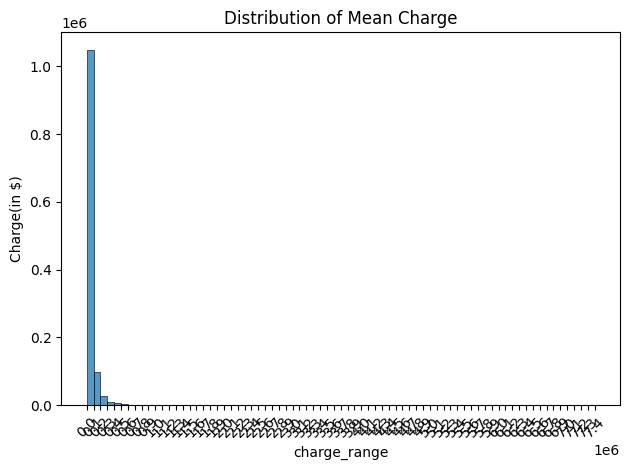

In [28]:
def hist_plot(series_data, x_label, y_label, title, bin_edges=None):
    sns.histplot(series_data, bins=bin_edges, kde=False)
    if bin_edges is not None:
        plt.xticks(bin_edges, rotation=45)  # Rotate for readability if many bins
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.tight_layout()
    plt.show()

# I rounded up 7456978.85 to 7500000
bin_edges = list(range(0, 7500000, 100000))
hist_plot(SPARCS_df['Mean Charge'], 'charge_range', 'Charge(in $)','Distribution of Mean Charge', bin_edges)

Actually seems like that largest mean price was a huge outlier. Lets maybe use a box plot to get a better visualization of outliers now

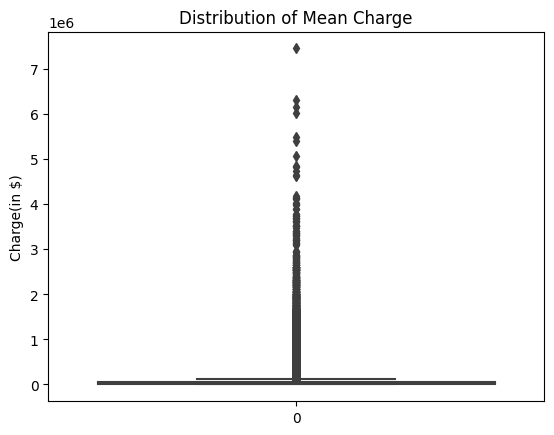

In [29]:
def box_plot(series_data, x_label, y_label, title,):
    sns.boxplot(series_data)
    plt.title(title)
    plt.ylabel(y_label)
    plt.show()

box_plot(SPARCS_df['Mean Charge'], 'charge_range', 'Charge(in $)','Distribution of Mean Charge')

So clearly there is a huge right skew here and its gonna make our lives very fun with trying to visualize this. So lets try to log scale this and go from there. I do this because it really brings down the effects of the outliers but we will have to see everything with a different perspective now.

In [30]:
log_mean_charges = np.log1p(SPARCS_df['Mean Charge'])
# lets see the max again to set bins properly
log_mean_charges.max()

15.824661044363236

Wow its down to just 15 this should hopefully help visualizing the splits. I will however set up a small step size so that we see some separation here because again we have to keep logscale in mind.

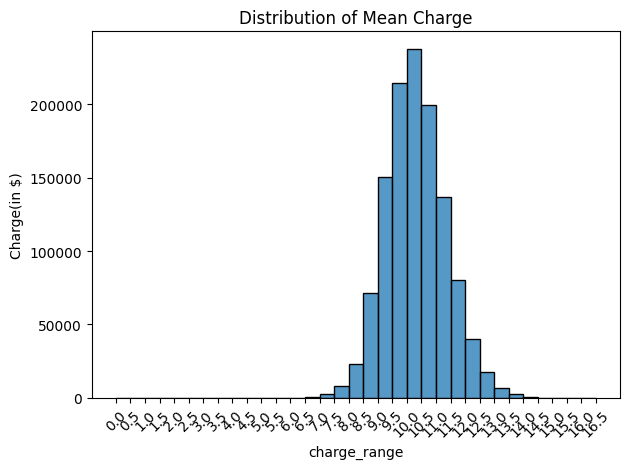

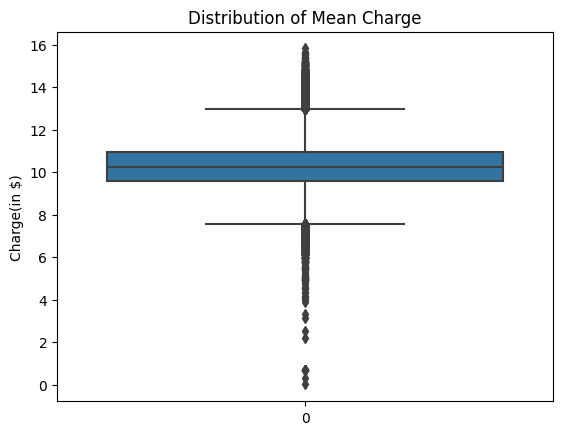

In [31]:
bin_edges = np.arange(0,17,.5)
hist_plot(log_mean_charges, 'charge_range', 'Charge(in $)','Distribution of Mean Charge', bin_edges)
box_plot(log_mean_charges, 'charge_range', 'Charge(in $)','Distribution of Mean Charge')

We can kind of see the distribution and in log scale it is normally distributed which means most hospital-condition-severity combinations have similar average charges which is also shown by the box plot being so short and having so much distance on each side to the whiskers. Off the box plot we can see that our median is close to 10.25 in log scale and the mean is around that ballpark as well and that we actually have quite a few outliers. But we can definetly conclude from the right skew of the original data that most of the hopital visits aren't as extreme as the $7456978.85 maximum price tag. 

Lets now see how average cost across the different hospitals varies. For this I will calculate the average value of each condition-severity combination after they are grouped by the hospital columns. Then I will average the top 10, middle 10, and the lowest 10 costliest hospitals and create a bar plot to visualize their differences in cost.

C:\Users\patel\AppData\Local\Temp\ipykernel_22156\3195781689.py:25: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


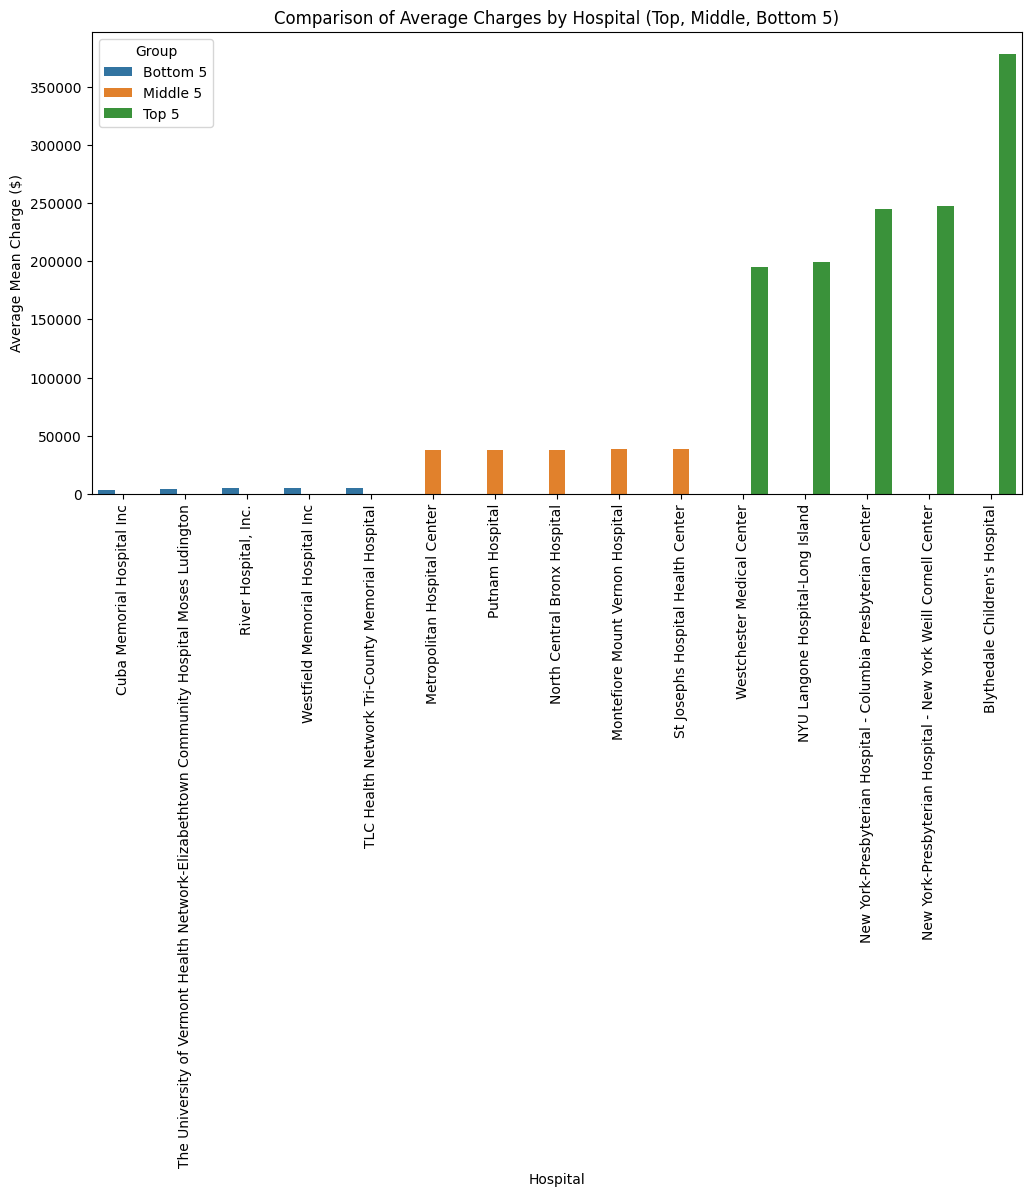

In [32]:
hospital_avg = SPARCS_df.groupby('Facility Name')['Mean Charge'].mean().sort_values()

top_10 = hospital_avg.tail(5)
bottom_10 = hospital_avg.head(5)

# For middle 10, we need to grab from the center
mid_index = len(hospital_avg) // 2
middle_10 = hospital_avg.iloc[mid_index - 3 : mid_index + 2]

df_plot = pd.concat([
    bottom_10.rename('Mean Charge').to_frame().assign(Group='Bottom 5'),
    middle_10.rename('Mean Charge').to_frame().assign(Group='Middle 5'),
    top_10.rename('Mean Charge').to_frame().assign(Group='Top 5')
])

# Reset index to get hospital names as column
df_plot = df_plot.reset_index().rename(columns={'Facility Name': 'Hospital'})

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(data=df_plot, x='Hospital', y='Mean Charge', hue='Group')
plt.xticks(rotation=90)
plt.title('Comparison of Average Charges by Hospital (Top, Middle, Bottom 5)')
plt.ylabel('Average Mean Charge ($)')
plt.tight_layout()
plt.show()

I mean we can see the hospitals but that doesnt really tell us much about why we are seeing this big difference in Average Mean Charge ($) between the lowest 5 and highest 5 hospitals. Although I see that 3 of the top 5 have terms that might be associated with NYC and maybe that is a trend considering its a big city and hence higher charges. Lets put that to the test and utilize geo pandas to visualize this. 

## Geopandas

But first I need to assign the address to each of these hospitals. I calculated the addressed of each of these hospitals so that I can use geopandas visualization with them. The calculation logic is shown in ./Extract_addresses.ipynb where I stored the resulting dictionary to hospital_to_add.json

In [33]:
import geopandas as gpd
import folium
from geopy.geocoders import Nominatim
from shapely.geometry import Point

In [34]:
# load the address and coord dictionary and load them onto the SPARCS df
with open('./hospital_to_add.json', 'r') as file:
    hospital_to_add = json.load(file)

with open('./hospital_to_coord.json', 'r') as file:
    hospital_to_coords = json.load(file)

SPARCS_df['Address'] = SPARCS_df['Facility Name'].map(hospital_to_add)
SPARCS_df['Latitude'] = SPARCS_df['Facility Name'].apply(lambda x: hospital_to_coords.get(x, (None, None))[0])
SPARCS_df['Longitude'] = SPARCS_df['Facility Name'].apply(lambda x: hospital_to_coords.get(x, (None, None))[1])

SPARCS_df.sample(n=5)

,Year,Facility Id,Facility Name,APR DRG Code,APR Severity of Illness Code,APR DRG Description,APR Severity of Illness Description,APR Medical Surgical Code,APR Medical Surgical Description,Discharges,Mean Charge,Median Charge,Mean Cost,Median Cost,Address,Latitude,Longitude
690720,2011,5,St Peters Hospital,175,4,Percutaneous Cardiovascular Procedures W/O Ami,Extreme,P,Surgical,7,121381.97,127692.25,31363.11,34144.28,"1 PINEWEST PLAZA SUITE 101, ALBANY, NY 12205",42.651167,-73.754968
455599,2013,103,UPMC Chautauqua at WCA,253,1,Other & Unspecified Gastrointestinal Hemorrhage,Minor,M,Medical,3,7850.95,4184.81,3475.63,2328.61,"207 FOOTE AVE, JAMESTOWN, NY 14701",42.091237,-79.231924
920592,2009,686,Orange Regional Medical Center-Middletown Campus,283,4,Other Disorders Of The Liver,Extreme,M,Medical,5,55765.00,41442.00,14993.00,10638.00,"700 E Main St, Middletown, NY 10940",41.450110,-74.416481
444703,2013,1740,Staten Island University Hosp-North,228,3,"Inguinal, Femoral & Umbilical Hernia Procedures",Major,P,Surgical,4,37521.64,34570.96,10049.30,8963.95,"475 Seaview Ave, Staten Island, NY 10305",40.585438,-74.084764
5597,2016,1178,Bronx-Lebanon Hospital Center - Concourse Divi...,121,2,Other Respiratory & Chest Procedures,Moderate,P,Surgical,4,20850.76,22347.24,24530.14,26324.70,"1650 Grand Concourse, Bronx, NY 10457",40.843489,-73.910573


In [35]:
facility_avg_cost = SPARCS_df.groupby(['Facility Name']).agg({'Mean Cost': 'mean'}).reset_index()
facility_avg_cost['Latitude'] = facility_avg_cost['Facility Name'].apply(lambda x: hospital_to_coords.get(x, (None, None))[0])
facility_avg_cost['Longitude'] = facility_avg_cost['Facility Name'].apply(lambda x: hospital_to_coords.get(x, (None, None))[1])

avg_cost_gdf = gpd.GeoDataFrame(
    facility_avg_cost,
    geometry=gpd.points_from_xy(facility_avg_cost['Longitude'], facility_avg_cost['Latitude']),
    crs='EPSG:4326'  # WGS84 Latitude/Longitude
)

avg_cost_gdf

,Facility Name,Mean Cost,Latitude,Longitude,geometry
0,A.O. Fox Memorial Hospital,10195.960185,42.457777,-75.051970,POINT (-75.05197 42.45778)
1,Adirondack Medical Center-Saranac Lake Site,17070.103017,44.322938,-74.122300,POINT (-74.1223 44.32294)
2,Albany Medical Center - South Clinical Campus,8742.412342,42.640632,-73.757756,POINT (-73.75776 42.64063)
3,Albany Medical Center Hospital,22336.810068,42.653213,-73.776679,POINT (-73.77668 42.65321)
4,Albany Memorial Hospital,10009.005310,42.673687,-73.748590,POINT (-73.74859 42.67369)
...,...,...,...,...,...
319,Womans Christian Assoc Hospital - WCA Hosp at ...,6051.744493,42.122012,-77.948058,POINT (-77.94806 42.12201)
320,Women And Children's Hospital Of Buffalo,21657.580876,42.886717,-78.878392,POINT (-78.87839 42.88672)
321,Woodhull Medical & Mental Health Center,30682.236289,40.699336,-73.942747,POINT (-73.94275 40.69934)
322,Wyckoff Heights Medical Center,18815.213232,40.652601,-73.949721,POINT (-73.94972 40.6526)


In [48]:
# Step 4: Create Folium map
m = folium.Map(location=[avg_cost_gdf['Latitude'].mean(), avg_cost_gdf['Longitude'].mean()], zoom_start=7)

# Add points
for idx, row in avg_cost_gdf.iterrows():
    folium.CircleMarker(
        location=(row['Latitude'], row['Longitude']),
        radius=5,
        popup=f"{row['Facility Name']}<br>Avg Mean Cost: ${row['Mean Cost']:.2f}",
        tooltip=f"{row['Facility Name']} - ${row['Mean Cost']:.2f}",
        color='blue',
        fill=True,
        fill_color='blue'
    ).add_to(m)

# Show map
m

Thats a pretty nice map but it would be better if we could actually visualize the dots with colors that represent the avg cost so we can see where the most high cost hospitals are. To visualize this lets calculate the quantile for the mean cost column. We will then color the points(hospitals) based on where their costs fall.

In [37]:
green_quantile = avg_cost_gdf['Mean Cost'].quantile(.25)
blue_quantile = avg_cost_gdf['Mean Cost'].quantile(.5)
yellow_quantile = avg_cost_gdf['Mean Cost'].quantile(.75)

def get_color(mean_cost):
    if mean_cost < green_quantile:
        return 'green'
    elif mean_cost < blue_quantile:
        return 'blue'
    elif mean_cost < yellow_quantile:
        return 'yellow'
    else:
        return 'red'

# Step 4: Create Folium map
m = folium.Map(location=[avg_cost_gdf['Latitude'].mean(), avg_cost_gdf['Longitude'].mean()], zoom_start=7)

# Add points with color based on Mean Cost
for idx, row in avg_cost_gdf.iterrows():
    color = get_color(row['Mean Cost'])
    folium.CircleMarker(
        location=(row['Latitude'], row['Longitude']),
        radius=5,
        popup=f"{row['Facility Name']}<br>Avg Mean Cost: ${row['Mean Cost']:.2f}",
        tooltip=f"{row['Facility Name']} - ${row['Mean Cost']:.2f}",
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.7
    ).add_to(m)

# Show map
m

Thats a bit better cause we are actually able to see where the costly hospitals are located and it seems like most of them are centered around NYC and it makes sense because the cost of living there is probably higher than anywhere else in NY. There are even way more hospitals in general around NYC and there are also quite a few scattered around the state that have a lost cost of visitation. So I'm assuming my model will probably learn that if the user says that they live in a major city in NY their cost for the visit will probably go up.

## Features

Alright enough fun with geo pandas and visualizing the target variable lets now compare its value across different categorical variable values. We'll start with the severity of illness of the admitted patient. 

In [38]:
def cat_plot(series_data, x_label, y_label, title):
    plt.figure(figsize=(10, 6))
    sns.countplot(x=series_data)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def mean_cost_plot(df, group_by_column, y_column='Mean Cost', 
                   x_label=None, y_label='Average Mean Cost', title=None):
    # Group by the chosen categorical column and calculate the mean cost
    mean_costs = df.groupby(group_by_column)[y_column].mean().sort_values(ascending=False)
    
    # Plot
    plt.figure(figsize=(10, 6))
    sns.barplot(x=mean_costs.index, y=mean_costs.values, palette='viridis')
    plt.xlabel(x_label if x_label else group_by_column)
    plt.ylabel(y_label)
    plt.title(title if title else f"Average {y_column} by {group_by_column}")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()



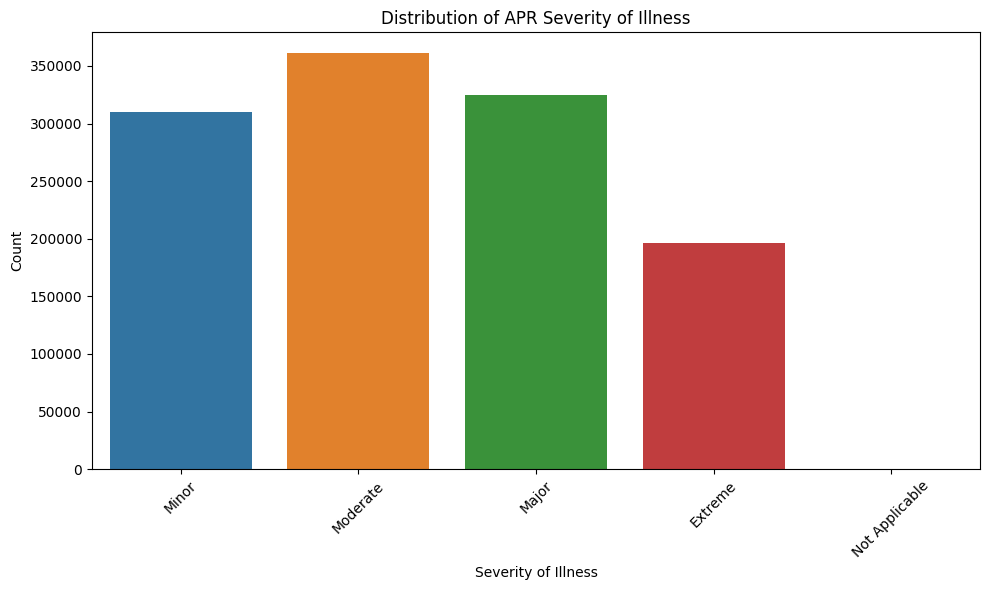

In [39]:
# Call the function like this
cat_plot(SPARCS_df['APR Severity of Illness Description'], 
         x_label="Severity of Illness", 
         y_label="Count", 
         title="Distribution of APR Severity of Illness")

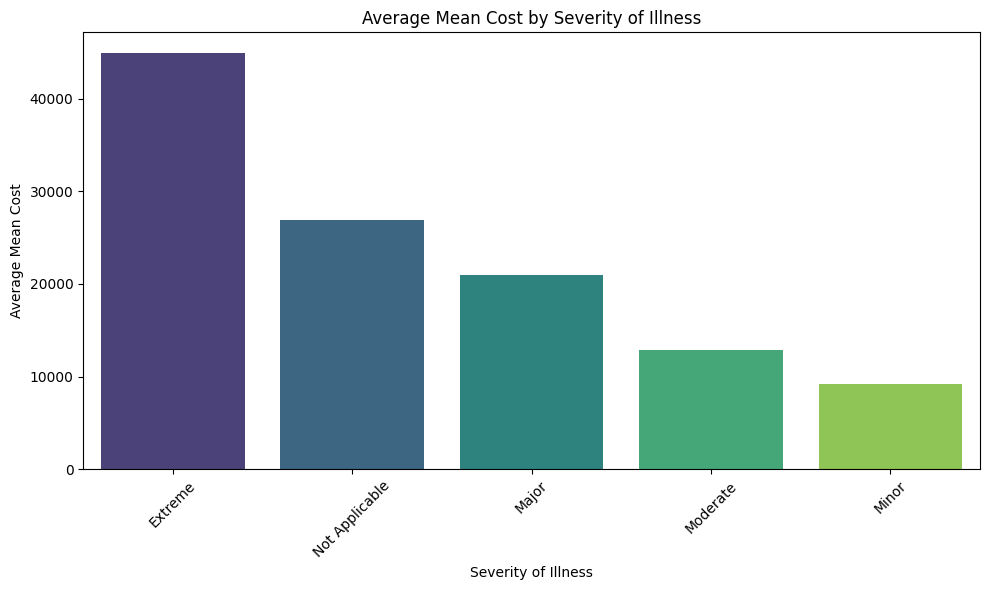

In [40]:
mean_cost_plot(SPARCS_df, 
               group_by_column='APR Severity of Illness Description',
               x_label="Severity of Illness", 
               title="Average Mean Cost by Severity of Illness")

Extreme severity of illness category accounts for only about 200,000 of the cases in the entire dataset which is about 16% of the total cases in the dataset but the average cost from these is well above the $40,000 mark.

Feature #2. We will do the same 2 visualizations for the APR Medical Surgical Description variable.

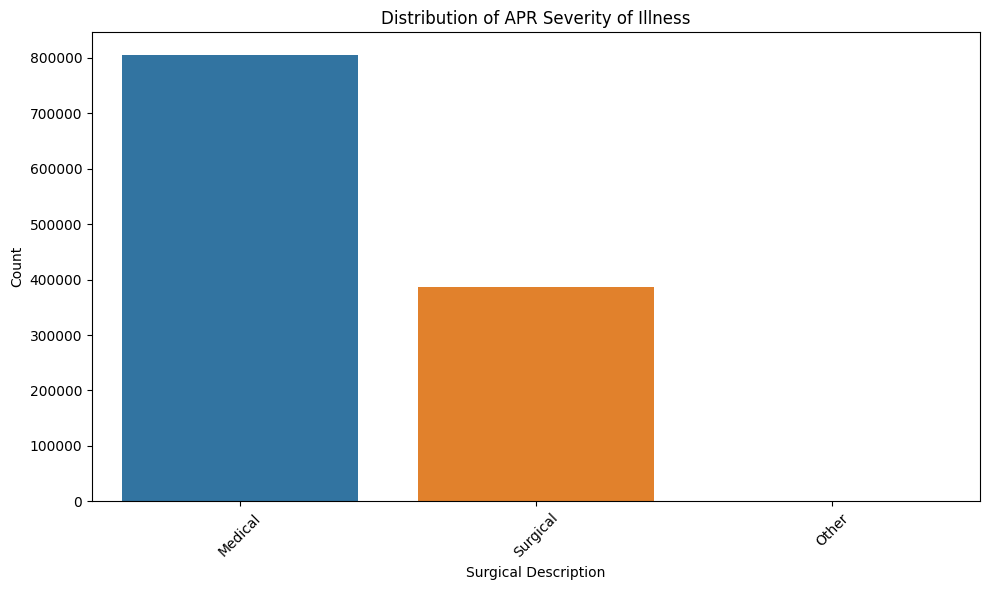

In [ ]:
cat_plot(SPARCS_df['APR Medical Surgical Description'], 
         x_label="Surgical Description", 
         y_label="Count", 
         title="Distribution of Surgical Descriptions")

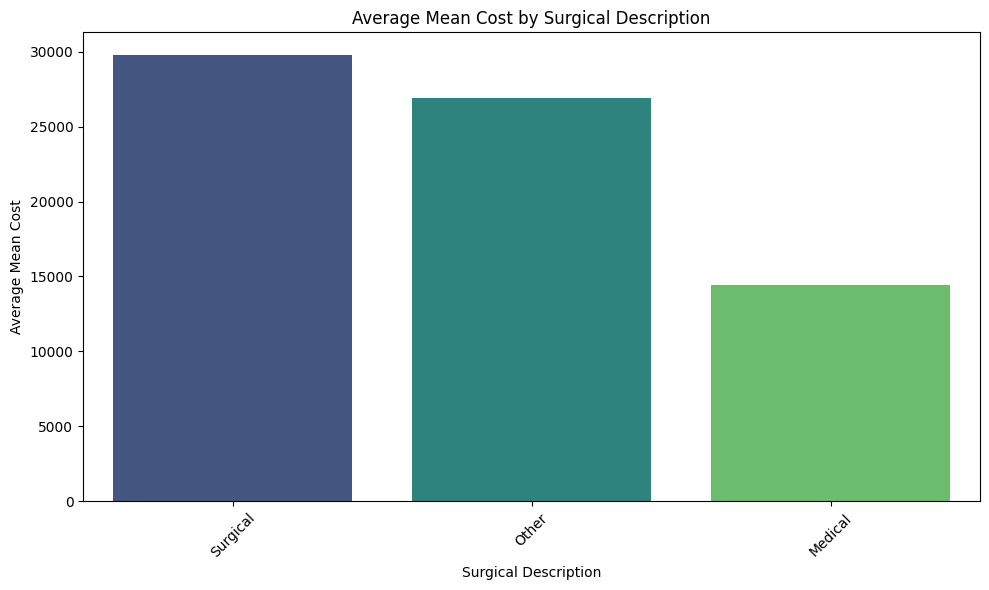

In [42]:
mean_cost_plot(SPARCS_df, 
               group_by_column='APR Medical Surgical Description',
               x_label="Surgical Description", 
               title="Average Mean Cost by Surgical Description")

Feature #3 APR DRG Description

In [46]:
len(SPARCS_df['APR DRG Description'].unique())

952

In [47]:
SPARCS_df['APR DRG Description'].unique()

array(['Heart Failure', 'Cardiac Arrest', 'Anal Procedures',
       'Abdominal Pain', 'Knee Joint Replacement', 'Digestive Malignancy',
       'Peptic Ulcer & Gastritis', 'Other Esophageal Disorders',
       'Tracheostomy W MV 96+ Hours W Extensive Procedure Or Ecmo',
       'Tracheostomy W MV 96+ Hours W/O Extensive Procedure',
       'Extracranial Vascular Procedures', 'Nervous System Malignancy',
       'Degenerative Nervous System Disorders Exc Mult Sclerosis',
       'Intracranial Hemorrhage', 'CVA & Precerebral Occlusion W Infarct',
       'Nonspecific CVA & Precerebral Occlusion W/O Infarct',
       'Transient Ischemia',
       'Peripheral, Cranial & Autonomic Nerve Disorders',
       'Nontraumatic Stupor & Coma', 'Seizure',
       'Migraine & Other Headaches', 'Other Disorders Of Nervous System',
       'Other Ear, Nose, Mouth & Throat Procedures',
       'Infections Of Upper Respiratory Tract',
       'Other Ear, Nose, Mouth,Throat & Cranial/Facial Diagnoses',
       'Major Re